In [16]:
# load the dataset
import tensorflow as tf
import pathlib

# create path
data_dir = '../tom_and_jerry/tom_and_jerry'
data_dir = pathlib.Path(data_dir)

# dataset parameters
batch_size = 32
img_height = 224
img_width = 224

# create dataset
train_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'))

# Function to extract label from file path
def get_label(file_path):
    parts = tf.strings.split(file_path, '/')
    return parts[-2] == class_names

def load_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

# read files into data / label pairs
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = load_image(img)
    return img, label

class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
train_ds = train_ds.map(process_path)
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size)


tf.Tensor([False  True], shape=(2,), dtype=bool)


2024-04-28 18:01:46.791018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


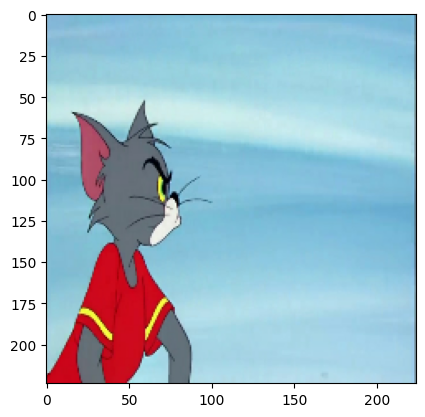

In [17]:
import matplotlib.pyplot as plt

for images, labels in iter(train_ds.take(1)):
    image = images[0]
    label = labels[0]
    plt.imshow(image / 255.0)
    print(label)

In [27]:
from tensorflow import keras
from tensorflow.keras import layers 

class VGG(keras.Model):
    def __init__(self):
        super().__init__()
    
        # unit 1
        self.norm   = layers.BatchNormalization()
        self.conv11 = layers.Conv2D(64, (3, 3), activation="relu")
        self.conv12 = layers.Conv2D(64, (3, 3), activation="relu")
        self.pool1  = layers.MaxPool2D(strides=(2, 2))

        # unit 2
        self.conv21 = layers.Conv2D(128, (3, 3), activation="relu")
        self.conv22 = layers.Conv2D(128, (3, 3), activation="relu")
        self.pool2  = layers.MaxPool2D(strides=(2, 2))

        # unit 3
        self.conv31 = layers.Conv2D(256, (3, 3), activation="relu")
        self.conv32 = layers.Conv2D(256, (3, 3), activation="relu")
        self.conv33 = layers.Conv2D(256, (3, 3), activation="relu")
        self.pool3  = layers.MaxPool2D(strides=(2, 2))

        # unit 4
        self.conv41 = layers.Conv2D(512, (3, 3), activation="relu")
        self.conv42 = layers.Conv2D(512, (3, 3), activation="relu")
        self.conv43 = layers.Conv2D(512, (3, 3), activation="relu")
        self.pool4  = layers.MaxPool2D(strides=(2, 2))

        # unit 5
        self.conv51 = layers.Conv2D(512, (3, 3), activation="relu")
        self.conv52 = layers.Conv2D(512, (3, 3), activation="relu")
        self.conv53 = layers.Conv2D(512, (3, 3), activation="relu")
        self.pool5  = layers.MaxPool2D(strides=(2, 2))

        # dense
        self.dense1 = layers.Dense(4096, activation="relu")
        self.dense2 = layers.Dense(4096, activation="relu")
        self.dense3 = layers.Dense(2, activation="sigmoid")
        self.flat = layers.Flatten()

    def call(self, input_data):
        x = input_data
        x = self.norm(x)

        # unit 1
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.pool1(x)

        # unit 2
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.pool2(x)

        # unit 3
        x = self.conv31(x)
        x = self.conv32(x)
        x = self.conv33(x)
        x = self.pool3(x)

        # unit 4
        x = self.conv41(x)
        x = self.conv42(x)
        x = self.conv43(x)
        x = self.pool4(x)

        # unit 5
        x = self.conv51(x)
        x = self.conv52(x)
        x = self.conv53(x)
        x = self.pool5(x)

        # dense
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.flat(x)
        return x

In [28]:
vgg = VGG()
input_shape = tuple(train_ds.element_spec[0].shape)
vgg.build(input_shape)
vgg.summary()

/home/mpan/Documents/ai-project/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'vgg_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "vgg_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
from tensorflow.keras import optimizers, losses, metrics

optimizer = optimizers.Adam(learning_rate=0.0003)
loss = losses.BinaryCrossentropy()
vgg.compile(optimizer=optimizer, loss=loss, metrics=[
    metrics.BinaryAccuracy(),
])

In [35]:
vgg.fit(train_ds, epochs=50)
vgg.save("./model_1.keras")

Epoch 1/50


100/100 ━━━━━━━━━━━━━━━━━━━━ 1269s 13s/step - binary_accuracy: 0.6059 - loss: 0.6714
Epoch 2/50
 19/100 ━━━━━━━━━━━━━━━━━━━━ 17:30 13s/step - binary_accuracy: 0.6557 - loss: 0.7189

KeyboardInterrupt: 